## Configuration

In [ ]:
!pip install mne

     |████████████████████████████████| 6.9MB 6.5MB/s 


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
%matplotlib inline
import numpy as np
import os
import pandas as pd
from scipy import io, signal
import time


from sklearn.pipeline import Pipeline
from sklearn.svm  import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

from mne import Epochs, pick_types, events_from_annotations, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import scipy.stats as st

## Utils

In [ ]:
def first_nonzero(arr, axis, invalid_val=-1):
    """
    Returns the first non-zero values along the specified axis.
    If there are no non-zero vealues it returns invalid_val
    """
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

## Read Data

In [ ]:
!unzip /content/drive/MyDrive/BCI_StrokeRehab/Risultati_2s.zip

Archive:  /content/drive/MyDrive/BCI_StrokeRehab/Risultati_2s.zip
replace Risultati/Processed_P1_post_test.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Risultati/Processed_P1_post_test.mat  
  inflating: Risultati/Processed_P1_post_training.mat  
  inflating: Risultati/Processed_P1_pre_test.mat  
  inflating: Risultati/Processed_P1_pre_training.mat  
  inflating: Risultati/Processed_P2_post_test.mat  
  inflating: Risultati/Processed_P2_post_training.mat  
  inflating: Risultati/Processed_P2_pre_test.mat  
  inflating: Risultati/Processed_P2_pre_training.mat  
  inflating: Risultati/Processed_P3_post_test.mat  
  inflating: Risultati/Processed_P3_post_training.mat  
  inflating: Risultati/Processed_P3_pre_test.mat  
  inflating: Risultati/Processed_P3_pre_training.mat  



* Trigger: +1 dx -1 sx 


* Structure of data dictionary:


```
  data = {"patient1":{
                      "pre" : {"train": {"DxRaw" : [],
                                       "DxFilt" : [],
                                       "SxRaw" : [],
                                       "SxFilt" : [],
                                       "tr" : []},

                              "test" : {"DxRaw" : [],
                                       "DxFilt" : [],
                                       "SxRaw" : [],
                                       "SxFilt" : [],
                                       "tr" : []}},

                      "post": {"train": {"DxRaw" : [],
                                        "DxFilt" : [],
                                        "SxRaw" : [],
                                        "SxFilt" : [],
                                        "tr" : []},

                               "test" : {"DxRaw" : [],
                                        "DxFilt" : [],
                                        "SxRaw" : [],
                                        "SxFilt" : [],
                                        "tr" : []}}},

          "patient2":{"pre":{...},
                     "post": {...}},

          "patient3":{...}
        }
```


In [ ]:
path = "/content/Risultati"

data = {"patient1":{"pre":{},
                    "post": {}},
        "patient2":{"pre":{},
                    "post": {}},
        "patient3":{"pre":{},
                    "post": {}}
        }

 
# Patient 1
processed_P1_pre_training = io.loadmat(path + '/Processed_P1_pre_training.mat')
processed_P1_pre_test = io.loadmat(path + '/Processed_P1_pre_test')
processed_P1_post_training= io.loadmat(path + '/Processed_P1_post_training.mat')
processed_P1_post_test= io.loadmat(path + '/Processed_P1_post_test.mat')

# Patient 2
processed_P2_pre_training = io.loadmat(path + '/Processed_P2_pre_training.mat')
processed_P2_pre_test = io.loadmat(path + '/Processed_P2_pre_test')
processed_P2_post_training= io.loadmat(path + '/Processed_P2_post_training.mat')
processed_P2_post_test= io.loadmat(path + '/Processed_P2_post_test.mat')

# Patient 3
processed_P3_pre_training = io.loadmat(path + '/Processed_P3_pre_training.mat')
processed_P3_pre_test = io.loadmat(path + '/Processed_P3_pre_test')
processed_P3_post_training= io.loadmat(path + '/Processed_P3_post_training.mat')
processed_P3_post_test= io.loadmat(path + '/Processed_P3_post_test.mat')

keys = list(processed_P1_pre_training.keys())
for key in keys[:3]:
  processed_P1_pre_training.pop(key)
  processed_P1_pre_test.pop(key)
  processed_P1_post_training.pop(key)
  processed_P1_post_test.pop(key)

  processed_P2_pre_training.pop(key)
  processed_P2_pre_test.pop(key)
  processed_P2_post_training.pop(key)
  processed_P2_post_test.pop(key)

  processed_P3_pre_training.pop(key)
  processed_P3_pre_test.pop(key)
  processed_P3_post_training.pop(key)
  processed_P3_post_test.pop(key)

data["patient1"]["pre"]["train"]= processed_P1_pre_training
data["patient1"]["pre"]["test"]= processed_P1_pre_training
data["patient1"]["post"]["train"] = processed_P1_pre_training
data["patient1"]["post"]["test"] = processed_P1_pre_training

data["patient2"]["pre"]["train"]= processed_P2_pre_training
data["patient2"]["pre"]["test"]= processed_P2_pre_training
data["patient2"]["post"]["train"] = processed_P2_pre_training
data["patient2"]["post"]["test"] = processed_P2_pre_training

data["patient3"]["pre"]["train"]= processed_P3_pre_training
data["patient3"]["pre"]["test"]= processed_P3_pre_training
data["patient3"]["post"]["train"] = processed_P3_pre_training
data["patient3"]["post"]["test"] = processed_P3_pre_training

In [ ]:
# Data shape
for k,v in data.items():
  for kk,vv, in v.items():
    print()
    for kkk, vvv in vv.items():
      for kkkk, vvvv in vvv.items():
          print(k, kk, kkk, kkkk,"shape:", vvvv.shape)
  print()


patient1 pre train DxFilt shape: (40, 16, 512)
patient1 pre train DxRaw shape: (40, 16, 512)
patient1 pre train SxFilt shape: (40, 16, 512)
patient1 pre train SxRaw shape: (40, 16, 512)
patient1 pre train tr shape: (1, 80)
patient1 pre test DxFilt shape: (40, 16, 512)
patient1 pre test DxRaw shape: (40, 16, 512)
patient1 pre test SxFilt shape: (40, 16, 512)
patient1 pre test SxRaw shape: (40, 16, 512)
patient1 pre test tr shape: (1, 80)

patient1 post train DxFilt shape: (40, 16, 512)
patient1 post train DxRaw shape: (40, 16, 512)
patient1 post train SxFilt shape: (40, 16, 512)
patient1 post train SxRaw shape: (40, 16, 512)
patient1 post train tr shape: (1, 80)
patient1 post test DxFilt shape: (40, 16, 512)
patient1 post test DxRaw shape: (40, 16, 512)
patient1 post test SxFilt shape: (40, 16, 512)
patient1 post test SxRaw shape: (40, 16, 512)
patient1 post test tr shape: (1, 80)


patient2 pre train DxFilt shape: (40, 16, 512)
patient2 pre train DxRaw shape: (40, 16, 512)
patient2 pr

# Training Models


## Utils

In [ ]:
def findDivisors(n):
  """Returns the list of divisors of n."""
  divisors = []
  i = 1
  for i in range(n):
      if (n % (i +1)==0) :
          divisors.append(i+1)
  return divisors


def build_y(data, label):

  return label * np.ones(len(data))


def prepare_data(data, patient = 'patient1', mode=['pre', 'Raw'], is_train = True):
    """
    Returns the desired training/test data and labels
    Parameters
    ----------
    data : dict 
    patient : str [default "patient1"]
    mode : list = ["pre" o "post", type of data], [deafult ['pre', 'Raw']]
    """
    if is_train:
      X = np.concatenate([
                          data['patient1']['pre']['train']['Dx'+mode[1]], 
                          data['patient1']['post']['train']['Sx'+mode[1]],
                          data['patient2']['pre']['train']['Dx'+mode[1]], 
                          data['patient2']['post']['train']['Sx'+mode[1]],
                          data['patient3']['pre']['train']['Dx'+mode[1]], 
                          data['patient3']['post']['train']['Sx'+mode[1]],
                          ]
                         )
      y= np.concatenate([ build_y(data['patient1']['pre']['train']['Dx'+mode[1]], -1), 
                          build_y(data['patient1']['post']['train']['Sx'+mode[1]] , 1),
                          build_y(data['patient2']['pre']['train']['Dx'+mode[1]], -1), 
                          build_y(data['patient2']['post']['train']['Sx'+mode[1]], 1),
                          build_y(data['patient3']['pre']['train']['Dx'+mode[1]], -1), 
                          build_y(data['patient3']['post']['train']['Sx'+mode[1]], 1),
                          ]
                         )
      X.shape, y.shape
    else:
      X = np.concatenate([
                          data[patient][mode[0]]['test']['Dx'+mode[1]], 
                          data[patient][mode[0]]['test']['Sx'+mode[1]]])
      y = np.concatenate([-1* np.ones((len(data[patient][mode[0]]['test']['Dx'+mode[1]]),), 'int8'),np.ones((len(data[patient][mode[0]]['test']['Sx'+mode[1]]),), 'int8')]) 
      X.shape, y.shape     
    return X, y

## Grid Search

In [ ]:
##########################
# Custimized Grid Search #
##########################

def customizedGridSearch(clf, csp, parameters_clf, parameters_csp, X_train, y_train):
    """
    Performs a 5-fold cross validation grid search on the specified classifier and vectorizer.
    
    Parameters
    ----------
      clf: classifier to be tested

      paramters_clf: list of values for the classifier hyperparameters

      paramters_csp: list of values for CSP hyperparameters

      X_train, y_train: train set 

    """

    
    # Grid Search pipeline
    pipeline = Pipeline([('csp', csp), ('clf', clf)])

    # Grid Search parameters
    parameters = dict()
    parameters.update(parameters_csp)
    parameters.update(parameters_clf)
    
    # 5-fold Cross Validation Grid Search
    grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=True)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)

    t0 = time.time()
    grid_search.fit(X_train, y_train)

    print("done in %0.3fs" % (time.time() - t0))
    print()
    # Best Model Result on CV
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    return grid_search 

def best_model_on_TestSet(grid_search, X_test, y_test):
    # Best Model Result on Test set
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    
    best_parameters = grid_search.best_estimator_.get_params()

    return best_parameters, grid_search.best_estimator_.score(X_test, y_test)

In [ ]:
##########################
# Grid Search Parameters #
##########################

# CSP parameters 
parameters_csp = {
    'csp__n_components' : (4,),
    'csp__log' : (True,)}


# LogReg or SVC Parameters
parameters_clf = { 'clf__C': (0.25, 0.5, 0.75,)}

# MLP Parameters
parameters_mlp = {'clf__hidden_layer_sizes': (100,),
                  'clf__activation' : ('relu',), 
                  'clf__max_iter': (1000,)}



# CSP
csp = CSP()

# Classifiers
lda = LinearDiscriminantAnalysis()
svc = SVC()
logreg= LogisticRegression()
mlp = MLPClassifier()


In [ ]:
X_train, y_train = prepare_data(data, is_train = True)
grid_search = customizedGridSearch(mlp, csp, parameters_mlp, parameters_csp, X_train, y_train)

Performing grid search...
pipeline: ['csp', 'clf']
parameters:
{'csp__n_components': (4,), 'csp__log': (True,), 'clf__hidden_layer_sizes': (100,), 'clf__activation': ('relu',), 'clf__max_iter': (1000,)}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Computing rank from data with rank=None


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


    Using tolerance 2.8e+02 (2.2e-16 eps * 16 dim * 7.9e+16  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 16 dim * 6.7e+16  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 9.503s

Best CV score: 0.594
Best parameters set:
	clf__activation: 'relu'
	clf__hidden_layer_sizes: 100
	clf__max_iter: 1000
	csp__log: True
	csp__n_components: 4


In [ ]:
total_scores = {}
chance_levels = {}
best_parameters = {}
patients = ['patient1', 'patient2', 'patient3']
mode_paramters = [['pre','Raw'],
                  ['pre','Filt'],
                  ['post','Raw'],
                  ['post','Filt']]

for patient in patients:
  total_scores[patient] = {}
  chance_levels[patient] = {}
  best_parameters[patient] = {}
  for mode in mode_paramters:
        print(patient, mode)
        X_test, y_test = prepare_data(data, patient, mode, is_train = False)
        best_params, scores = best_model_on_TestSet(grid_search, X_test, y_test)

        class_balance = np.mean(y_test == y_test[0])
        class_balance = max(class_balance, 1. - class_balance)
        total_scores[patient][mode[0] + '_'+ mode[1]] = np.mean(scores)
        chance_levels[patient][mode[0] + '_'+ mode[1]] = class_balance
        best_parameters[patient][mode[0] + '_'+ mode[1]] = best_params

patient1 ['pre', 'Raw']
Test score with best_estimator_: 0.738


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.72      0.78      0.75        40
           1       0.76      0.70      0.73        40

    accuracy                           0.74        80
   macro avg       0.74      0.74      0.74        80
weighted avg       0.74      0.74      0.74        80

patient1 ['pre', 'Filt']
Test score with best_estimator_: 0.500


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        40
           1       0.50      1.00      0.67        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80

patient1 ['post', 'Raw']
Test score with best_estimator_: 0.738


Classification Report Test Data
              precision    recall  f1-score   support

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Test score with best_estimator_: 0.750


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.76      0.72      0.74        40
           1       0.74      0.78      0.76        40

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80

patient2 ['post', 'Filt']
Test score with best_estimator_: 0.500


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        40
           1       0.50      1.00      0.67        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80

patient3 ['pre', 'Raw']
Test score with best_estimator_: 0.734


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.7

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
total_scores

{'patient1': {'post_Filt': 0.5,
  'post_Raw': 0.7375,
  'pre_Filt': 0.5,
  'pre_Raw': 0.7375},
 'patient2': {'post_Filt': 0.5,
  'post_Raw': 0.75,
  'pre_Filt': 0.5,
  'pre_Raw': 0.75},
 'patient3': {'post_Filt': 0.5063291139240507,
  'post_Raw': 0.7341772151898734,
  'pre_Filt': 0.5063291139240507,
  'pre_Raw': 0.7341772151898734}}

# Models Comparison



## Utils

In [ ]:
def confidence_interval(acc, n, conf = .95):
  """
  Returns the extremes of the confidence interval given the desired confidence ('conf'),
  the model accuracy ('acc'), and the number of samples ('n').

  Parameters
  ----------
      acc [double]: model accuracy
      n [int]: number of samples
      conf [float, default 0.95]: confidence
  """

  alpha = 1 - conf 
  z = np.absolute(st.norm.ppf(alpha/2)) # Two tails

  sqrt =(z**2 + 4*n*acc - 4*n*acc**2)**.5
  rho_max = (2*n*acc + z**2 + z*sqrt) / (2*(n + z**2))
  rho_min = (2*n*acc + z**2 - z*sqrt) / (2*(n + z**2))

  return [rho_min, rho_max]

def plot_models_acc(patient1, patient2, patient3, N, alpha =.95, title = 'CSP + MLP'):
  
    
    for patient, name, color in zip([patient1, patient2, patient3],['P1','P2', 'P3'],['blue', 'orange','green']):
      # Get confidence interval
      models_CI = []
      for acc in patient.values():
        models_CI.append(confidence_interval(acc, N, conf=alpha))

      # Plot
      plt.figure(figsize=(10,6))
      err= [x-y[0] for x,y in zip(patient.values(), models_CI)]
      ticks = range(len(patient))
      plt.errorbar(ticks, patient.values(), yerr=err, fmt='o', c='green')
      plt.ylabel('Accuracy', color = 'black')
      plt.title(title + ' - ' + name, color = 'black')
      plt.yticks(color = 'black')
      plt.xticks(ticks, patient.keys(), rotation = 50, color = 'b')
      #plt.legend();

## Comparison

In [ ]:
###################
# MODELS ACCURACY #
###################

#-----------------------------
# CSP + MLP + 6s
#-----------------------------
"""
Best CV score: 0.611
Best parameters set:
	clf__activation: 'relu'
	clf__hidden_layer_sizes: 100
	clf__max_iter: 1000
	csp__log: True
	csp__n_components: 8

patient1 = {'post_Filt': 0.55,
  'post_Raw': 0.825,
  'pre_Filt': 0.55,
  'pre_Raw': 0.825}

patient2= {'post_Filt': 0.4875,
  'post_Raw': 0.95,
  'pre_Filt': 0.4875,
  'pre_Raw': 0.95}

patient3 = {'post_Filt': 0.4936708860759494,
  'post_Raw': 0.7848101265822784,
  'pre_Filt': 0.4936708860759494,
  'pre_Raw': 0.7848101265822784}
"""
#-----------------------------
# CSP + MLP + 8s
#-----------------------------

"""Best CV score: 0.594
Best parameters set:
	clf__activation: 'relu'
	clf__hidden_layer_sizes: 100
	clf__max_iter: 1000
	csp__log: True
	csp__n_components: 8
"""
patient1 = {'post_Filt': 0.5,
  'post_Raw': 0.7375,
  'pre_Filt': 0.5,
  'pre_Raw': 0.7375}
patient2= {'post_Filt': 0.5,
  'post_Raw': 0.75,
  'pre_Filt': 0.5,
  'pre_Raw': 0.75}
patient3= {'post_Filt': 0.5063291139240507,
  'post_Raw': 0.7341772151898734,
  'pre_Filt': 0.5063291139240507,
  'pre_Raw': 0.7341772151898734}



#-----------------------------
# CSP + MLP 6s single
#-----------------------------

patient1= {'post_Filt': 0.85,
  'post_Raw': 0.8125,
  'pre_Filt': 0.85,
  'pre_Raw': 0.8125}
  
patient2= {'post_Filt': 0.85,
  'post_Raw': 0.8625,
  'pre_Filt': 0.85,
  'pre_Raw': 0.8625}
  
patient3= {'post_Filt': 0.8354430379746836,
  'post_Raw': 0.8481012658227848,
  'pre_Filt': 0.8354430379746836,
  'pre_Raw': 0.8481012658227848}


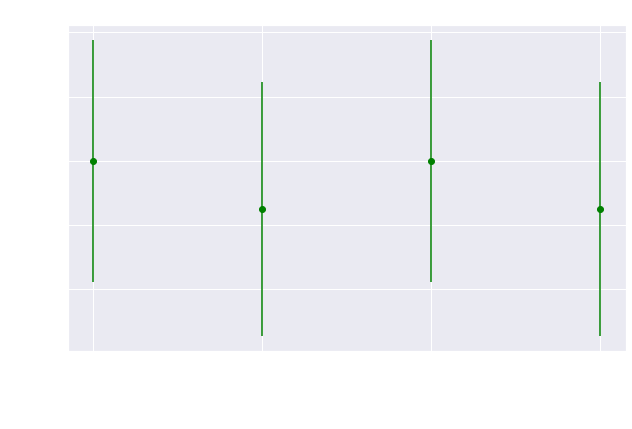

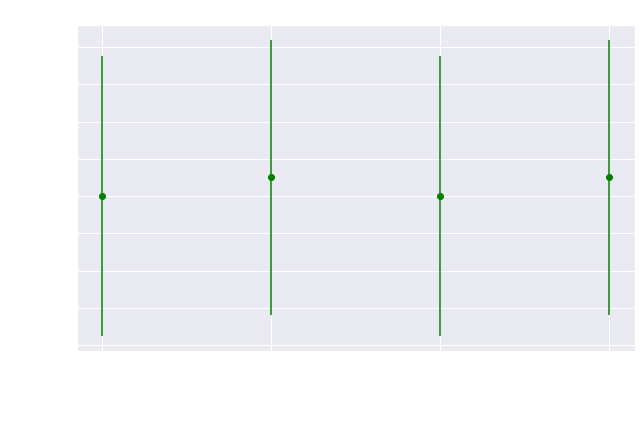

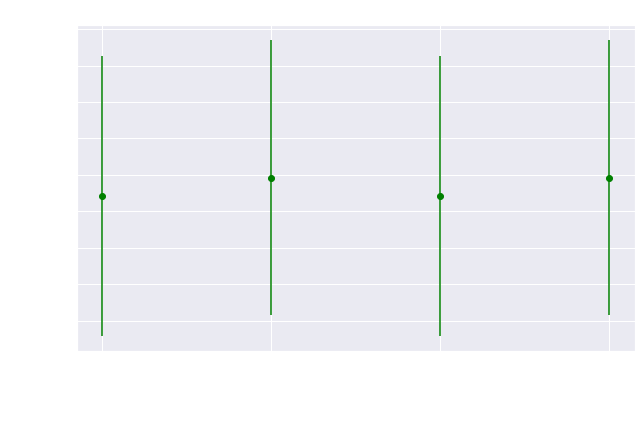

In [ ]:
plot_models_acc(patient1, patient2, patient3, N=80, alpha = .95, title = 'CSP + MLP + 2s');

# Results

## CSP + MLP

CSP parameters 
  >parameters_csp = {
      'csp__n_components' : (4, 6, 8),
      'csp__log' : (True, None)}

Logistic Regression Parameters
  >parameters_mlp = {'clf__hidden_layer_sizes': (20, 50, 100,),
                  'clf__activation' : ('relu',), 
                  'clf__max_iter': (200, 500, 1000)}

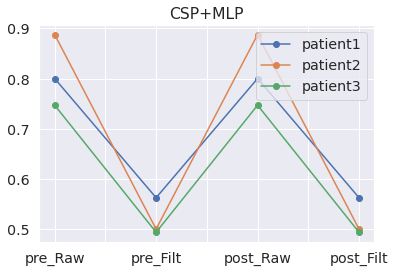

In [ ]:
pd.DataFrame(total_scores).plot( marker= 'o', title = "CSP+MLP");

In [ ]:
best_parameters

{'patient1': {'post_Filt': {'clf': MLPClassifier(hidden_layer_sizes=50, max_iter=1000),
   'clf__activation': 'relu',
   'clf__alpha': 0.0001,
   'clf__batch_size': 'auto',
   'clf__beta_1': 0.9,
   'clf__beta_2': 0.999,
   'clf__early_stopping': False,
   'clf__epsilon': 1e-08,
   'clf__hidden_layer_sizes': 50,
   'clf__learning_rate': 'constant',
   'clf__learning_rate_init': 0.001,
   'clf__max_fun': 15000,
   'clf__max_iter': 1000,
   'clf__momentum': 0.9,
   'clf__n_iter_no_change': 10,
   'clf__nesterovs_momentum': True,
   'clf__power_t': 0.5,
   'clf__random_state': None,
   'clf__shuffle': True,
   'clf__solver': 'adam',
   'clf__tol': 0.0001,
   'clf__validation_fraction': 0.1,
   'clf__verbose': False,
   'clf__warm_start': False,
   'csp': CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
     log=True, n_components=8, norm_trace=False, rank=None, reg=None,
     transform_into='average_power'),
   'csp__component_order': 'mutual_info',
   'csp__co

## CSP + SVC

CSP parameters 
  >parameters_csp = {
      'csp__n_components' : (4, 6, 8),
      'csp__log' : (True, None)}

Logistic Regression Parameters
  >parameters_clf = {'clf__C': (0.25, 0.5, 0.75,)}

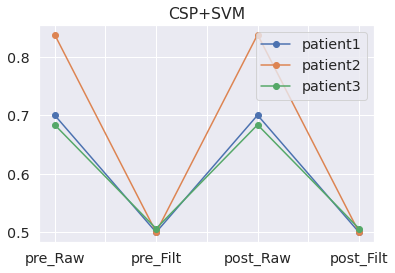

In [ ]:
pd.DataFrame(total_scores).plot( marker= 'o', title = "CSP+SVM");

In [ ]:
best_parameters

{'patient1': {'post_Filt': {'clf': SVC(C=0.5),
   'clf__C': 0.5,
   'clf__break_ties': False,
   'clf__cache_size': 200,
   'clf__class_weight': None,
   'clf__coef0': 0.0,
   'clf__decision_function_shape': 'ovr',
   'clf__degree': 3,
   'clf__gamma': 'scale',
   'clf__kernel': 'rbf',
   'clf__max_iter': -1,
   'clf__probability': False,
   'clf__random_state': None,
   'clf__shrinking': True,
   'clf__tol': 0.001,
   'clf__verbose': False,
   'csp': CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
     log=True, n_components=8, norm_trace=False, rank=None, reg=None,
     transform_into='average_power'),
   'csp__component_order': 'mutual_info',
   'csp__cov_est': 'concat',
   'csp__cov_method_params': None,
   'csp__log': True,
   'csp__n_components': 8,
   'csp__norm_trace': False,
   'csp__rank': None,
   'csp__reg': None,
   'csp__transform_into': 'average_power',
   'memory': None,
   'steps': [('csp',
     CSP(component_order='mutual_info', cov_est='c

## CSP + LogReg

CSP parameters 
  >parameters_csp = {
      'csp__n_components' : (4, 6, 8),
      'csp__log' : (True, None)}

Logistic Regression Parameters
  >parameters_clf = {'clf__C': (0.25, 0.5, 0.75,)}

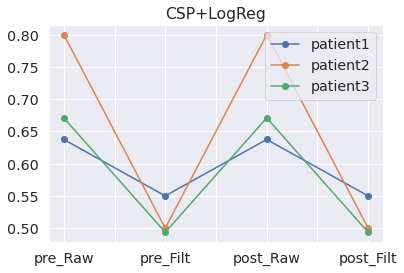

In [ ]:
pd.DataFrame(total_scores).plot( marker= 'o', title = "CSP+LogReg");

In [ ]:
best_parameters

{'patient1': {'post_Filt': {'clf': LogisticRegression(C=0.25),
   'clf__C': 0.25,
   'clf__class_weight': None,
   'clf__dual': False,
   'clf__fit_intercept': True,
   'clf__intercept_scaling': 1,
   'clf__l1_ratio': None,
   'clf__max_iter': 100,
   'clf__multi_class': 'auto',
   'clf__n_jobs': None,
   'clf__penalty': 'l2',
   'clf__random_state': None,
   'clf__solver': 'lbfgs',
   'clf__tol': 0.0001,
   'clf__verbose': 0,
   'clf__warm_start': False,
   'csp': CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
     log=True, n_components=8, norm_trace=False, rank=None, reg=None,
     transform_into='average_power'),
   'csp__component_order': 'mutual_info',
   'csp__cov_est': 'concat',
   'csp__cov_method_params': None,
   'csp__log': True,
   'csp__n_components': 8,
   'csp__norm_trace': False,
   'csp__rank': None,
   'csp__reg': None,
   'csp__transform_into': 'average_power',
   'memory': None,
   'steps': [('csp',
     CSP(component_order='mutual_inf